In [1]:
import pandas as pd
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

In [6]:
simDF = pd.read_csv("../data/simRun_optimistic.txt",sep=",")

In [68]:
for n in np.unique(simDF['night']):
    msk = simDF['night']==n
    t = Time(simDF[msk]['mjd'].iloc[-1], format="mjd") - Time(simDF[msk]['mjd'].iloc[0],format="mjd")
    print(t,"d of ToO observation time for night {}".format(n))

0.007064814824843779 d of ToO observation time for night 0
0.007064814824843779 d of ToO observation time for night 1
0.007064814824843779 d of ToO observation time for night 2
0.007064814824843779 d of ToO observation time for night 3


In [52]:
t.datetime

datetime.timedelta(seconds=610, microseconds=400001)

In [59]:
ev_name = "S250830bp"
ev_start = 60917 # Event start in MJD

In [17]:
_18kMap = hp.read_map("https://gracedb.ligo.org/api/superevents/{}/files/bayestar.fits.gz".format(ev_name))
i = np.flipud(np.argsort(_18kMap))
sorted_credible_levels = np.cumsum(_18kMap[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels

In [18]:
maskMap =  np.zeros_like(_18kMap)
maskMap[credible_levels<=0.9]=2
maskMap[credible_levels<=0.5]=1

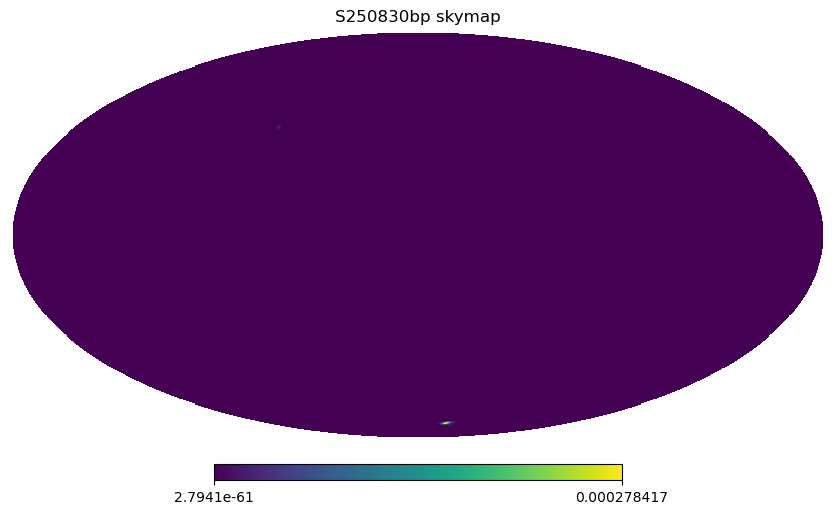

In [19]:
hp.mollview(_18kMap,title="{} skymap".format(ev_name))

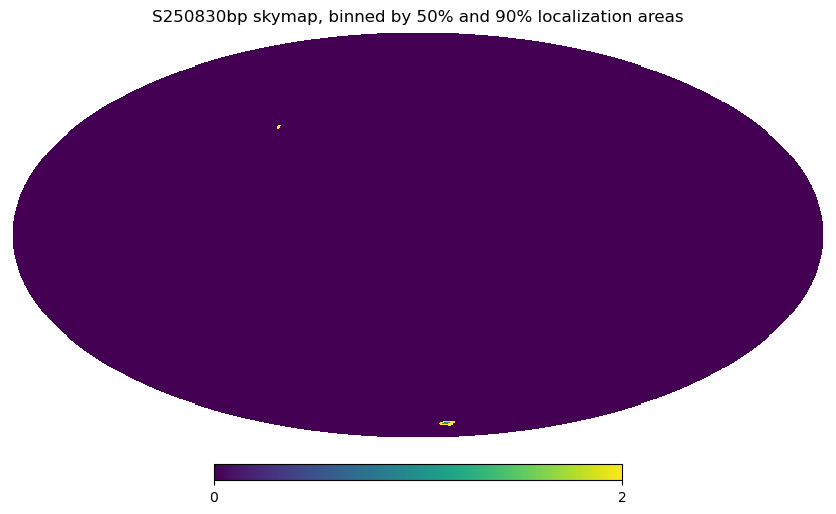

In [20]:
hp.mollview(maskMap,title="{} skymap, binned by 50% and 90% localization areas".format(ev_name))

In [21]:
tot50,frac50,tot90,frac90 = 0,0,0,0

In [22]:
def getStats(mask,tile,maskFills):
    result=[]
    for fill in maskFills:
        totalOv = healpix_overlap(mask,tile,fill_value=fill)
        # print("Total: {}".format(totalOv))
        maskReg = getMaskReg(mask,fill)
        # print("maskReg: {}".format(maskReg))
        result.append(totalOv)
        result.append(totalOv/maskReg * 100)
    return result

def healpix_overlap(map1, map2, fill_value=hp.UNSEEN, nside=None, area=True):
    # Both maps should be np.ndarray of same length
    if map1.shape != map2.shape:
        raise ValueError("Maps must have the same number of pixels.")

    # Mask out fill values
    valid = (map1 == fill_value[0]) & (map2 == fill_value[1])
    
    # Count overlap
    count = len(map1[valid])

    if not area:
        return count

    # Compute area per pixel
    if nside is None:
        nside = hp.get_nside(map1)
    pix_area = hp.nside2pixarea(nside,degrees=True)  # steradians per pixel

    return count * pix_area

def getMaskReg(mask,fill):
    return hp.nside2pixarea(hp.get_nside(mask),degrees=True) * len(mask[mask==fill[0]])

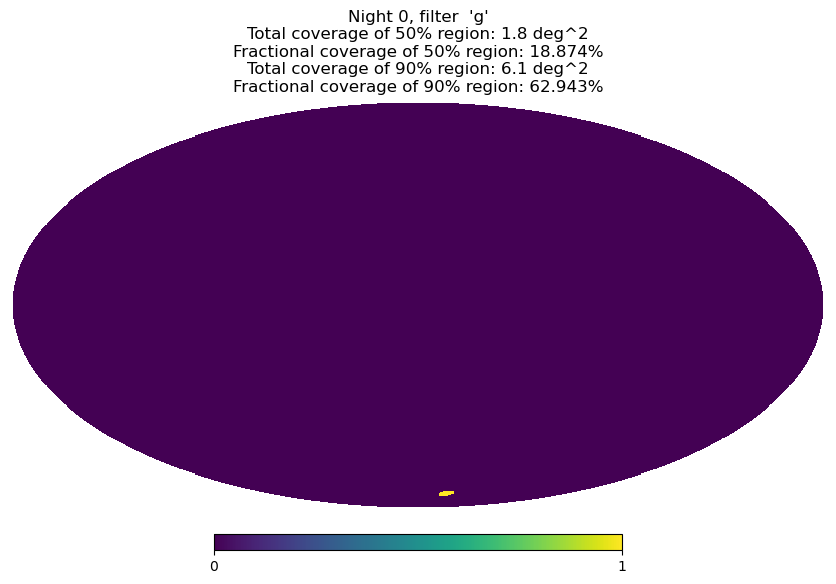

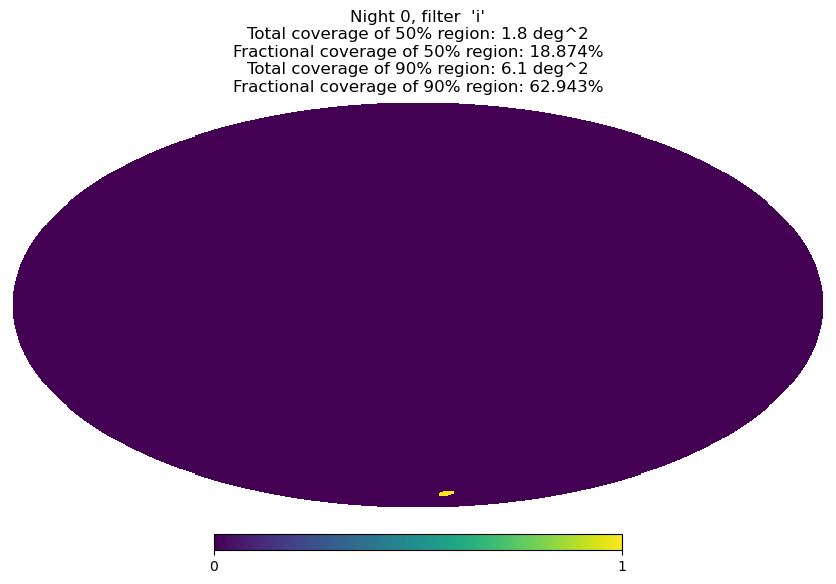

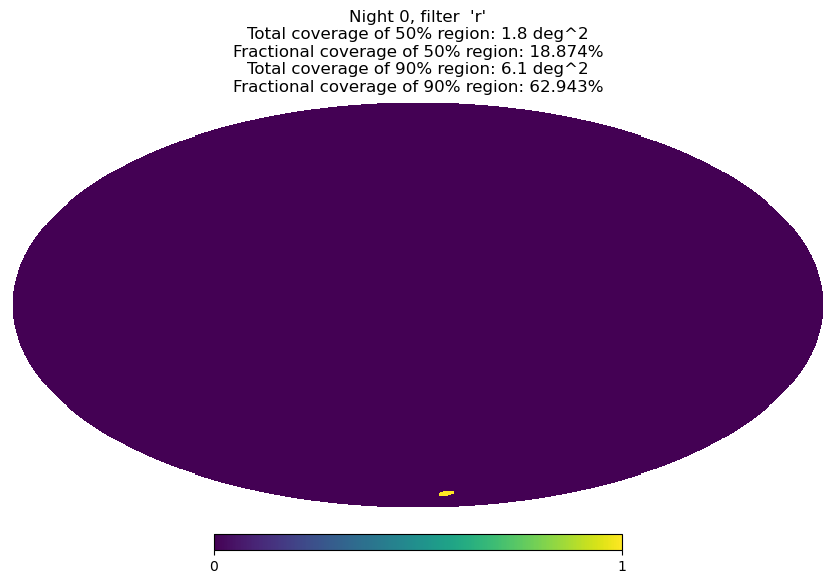

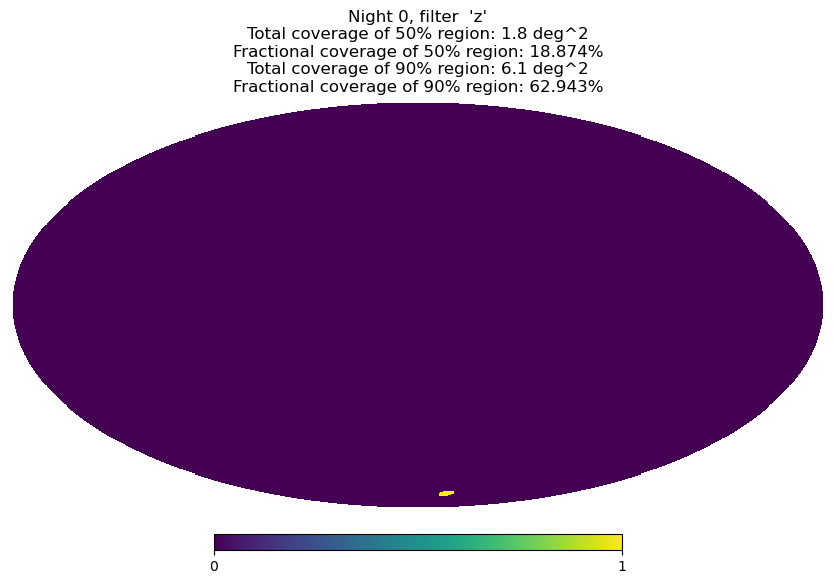

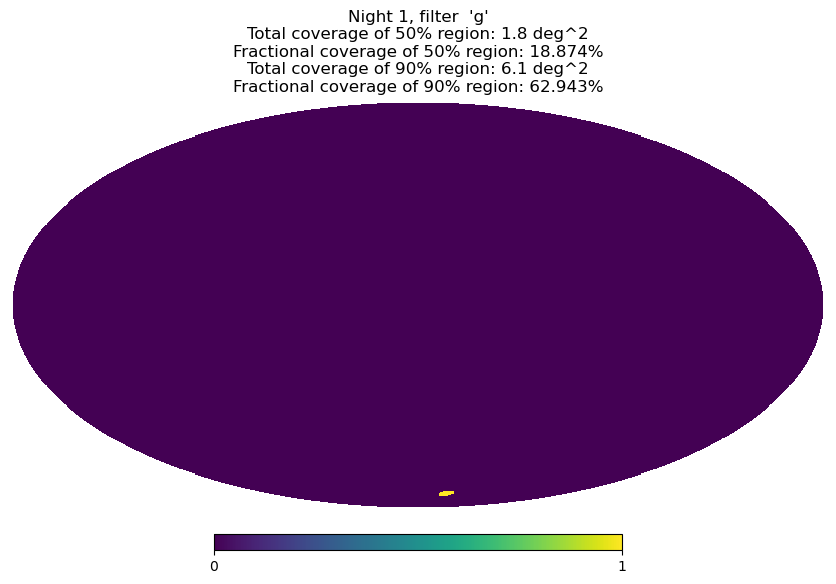

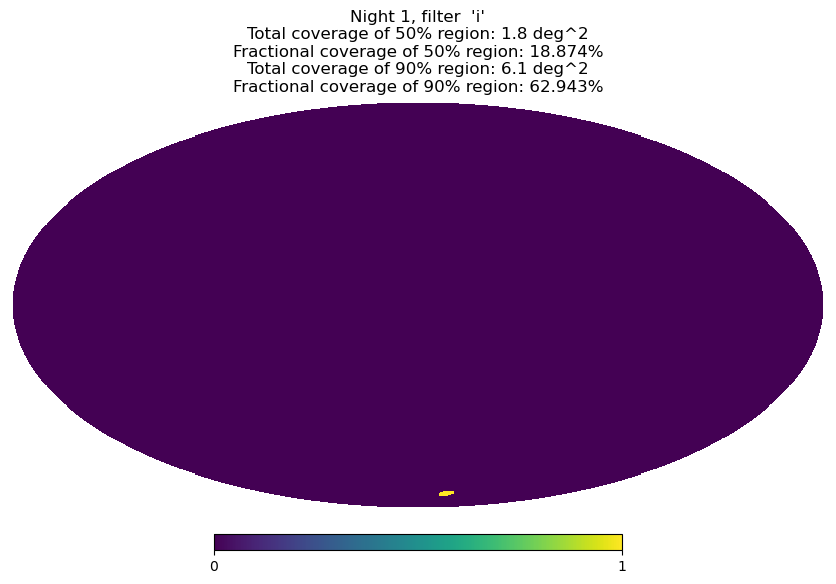

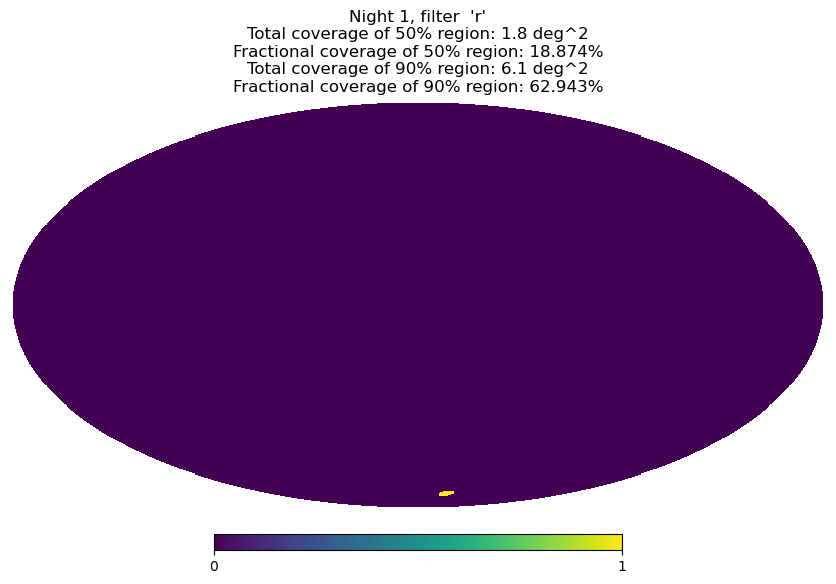

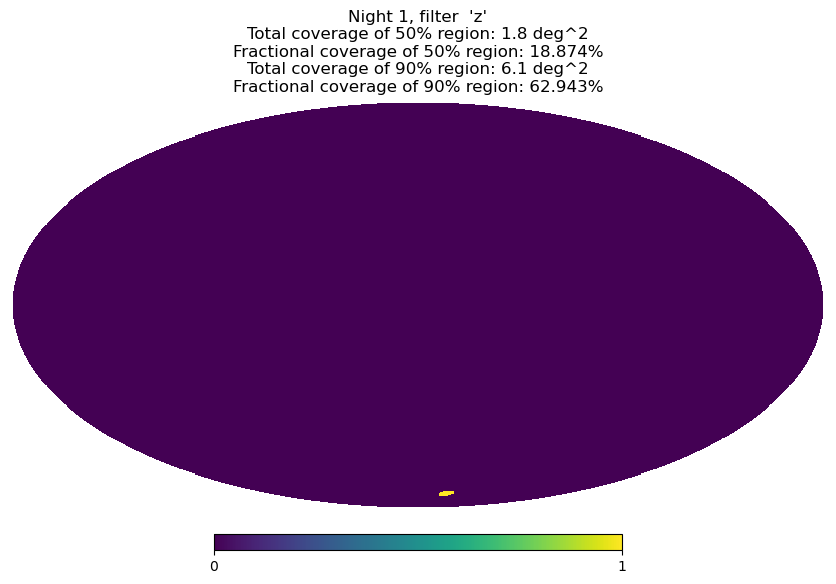

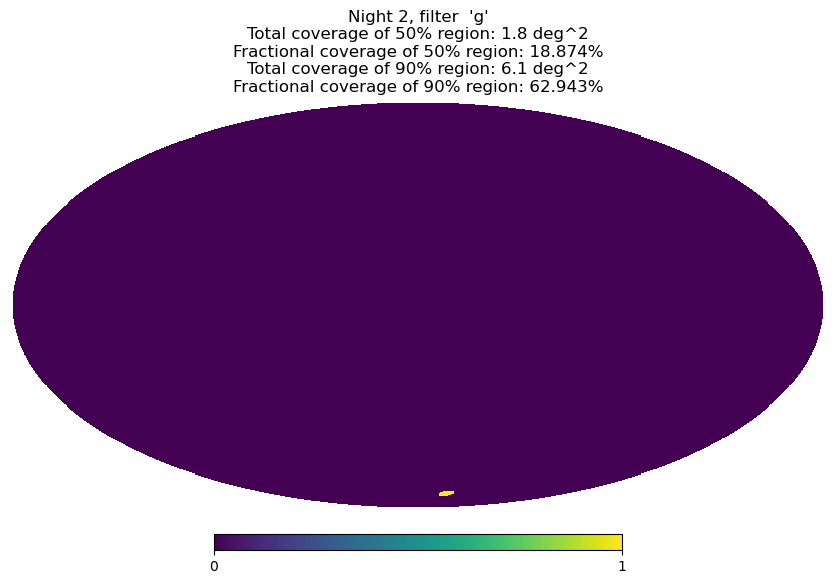

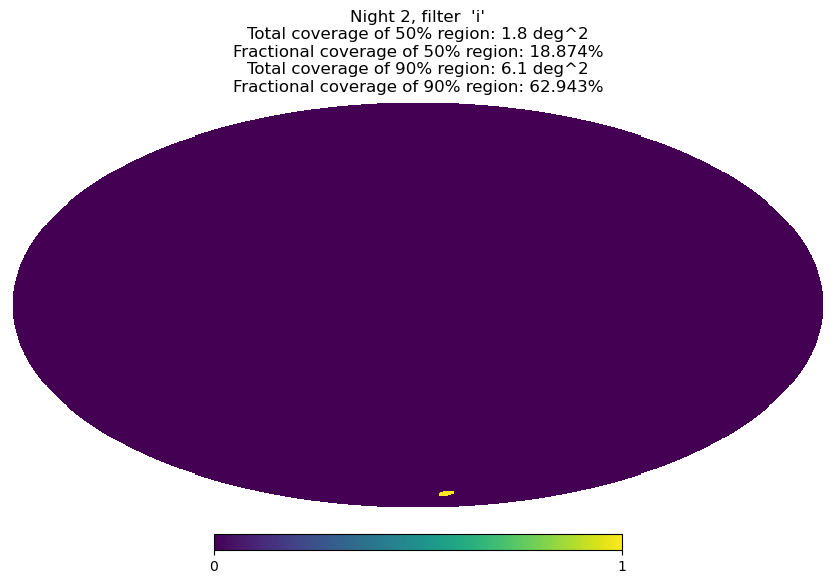

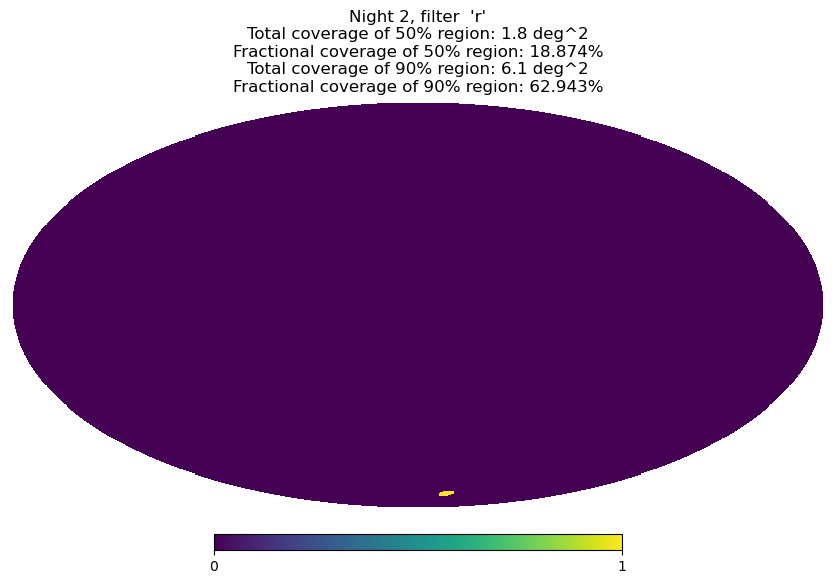

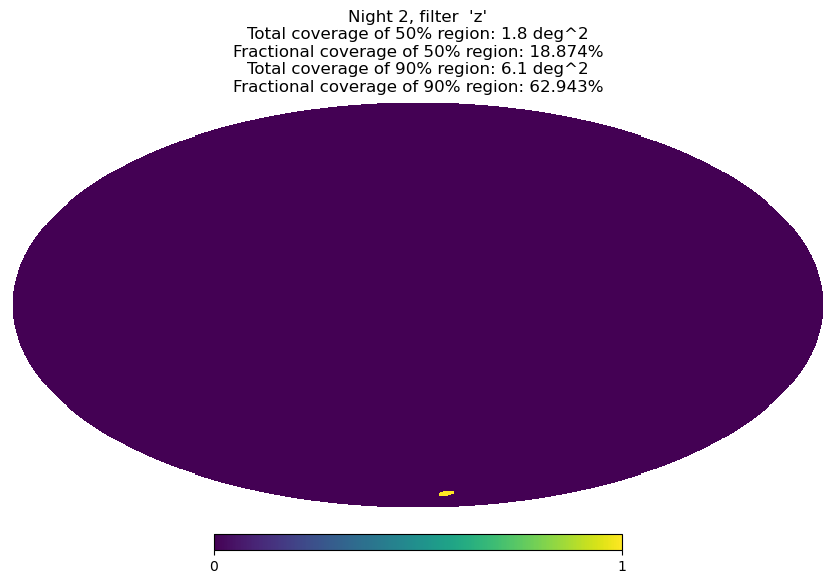

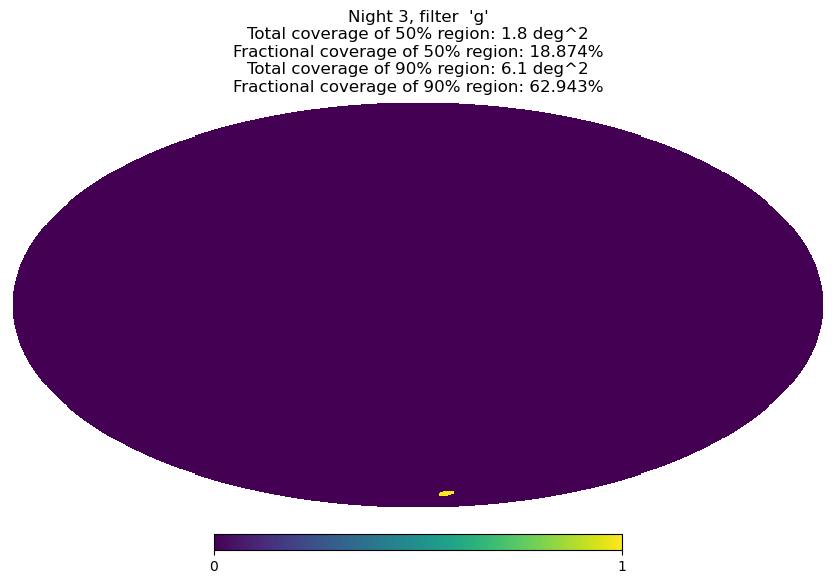

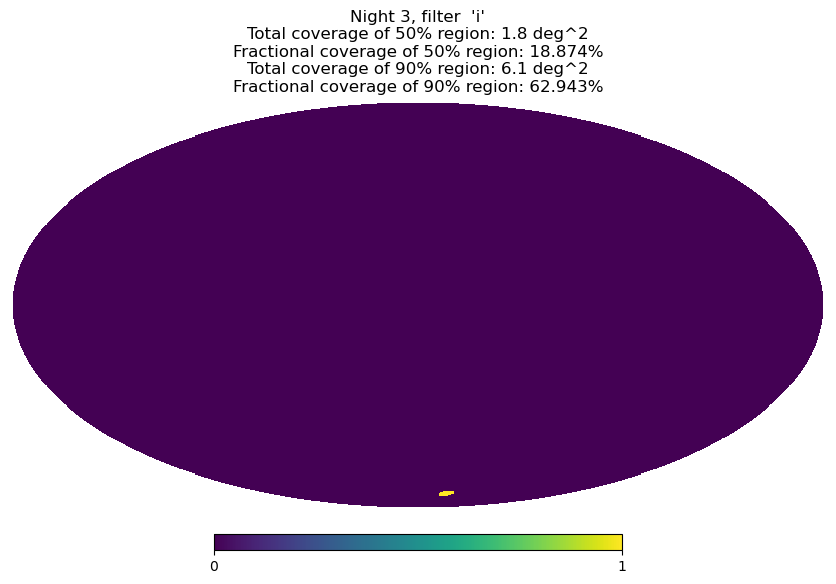

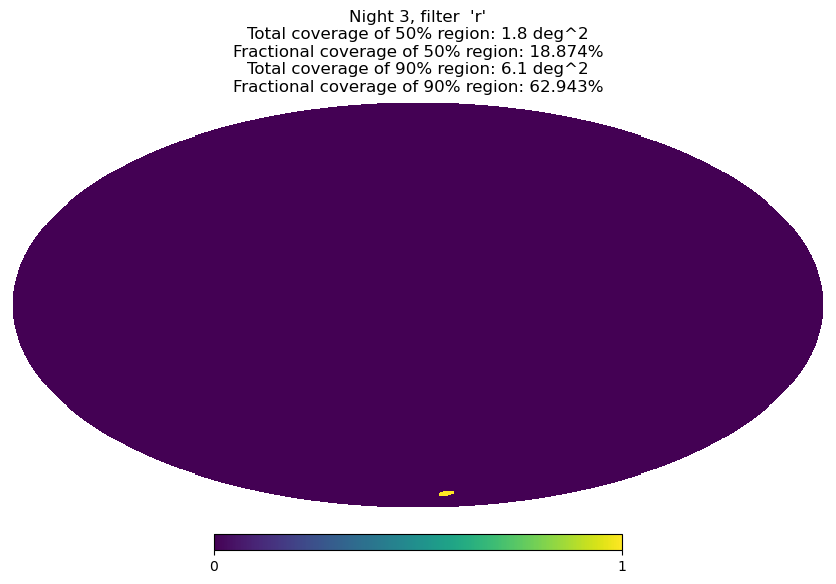

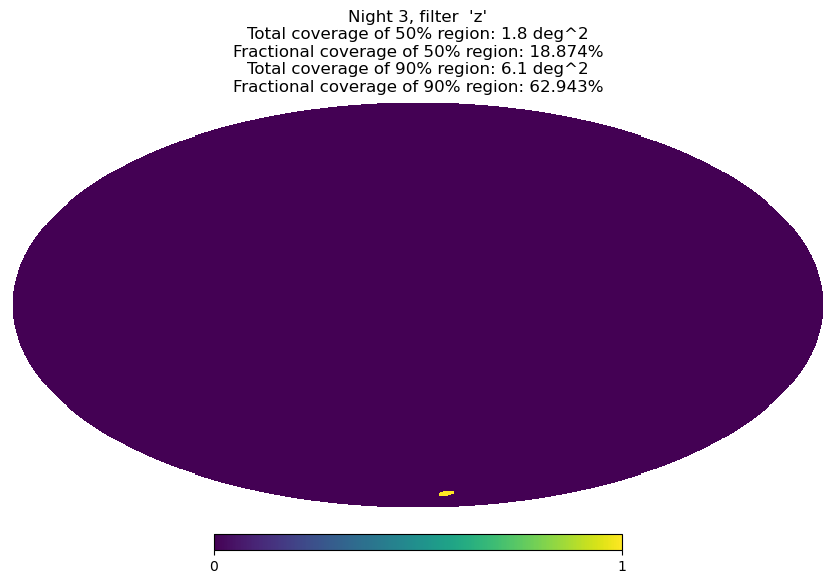

In [42]:
tot,frac=[],[]
for night in np.unique(simDF["night"]):
    nightMask = np.array(simDF['night']==night)
    for f in np.unique(simDF[nightMask]["band"]):
        fmask = [x.__contains__(f) for x in simDF['band']]
        myMask = np.logical_and(nightMask,fmask)
        filteredDF = simDF[myMask]
        tileMap = np.zeros_like(_18kMap)
        for __,r in simDF[myMask].iterrows():
            indices = hp.query_disc(hp.get_nside(tileMap),hp.ang2vec(-r['dec']+np.pi/2,r["RA"],lonlat=False),1.75*np.pi/180)
            tileMap[indices]=1

        # Compute statistics
        tot50,frac50,tot90,frac90 = getStats(tileMap,maskMap,[[1,1],[1,2]])
        tot.append(tot50)
        tot.append(tot90)
        frac.append(frac50)
        frac.append(frac90)
        # Make plot
        hp.mollview(tileMap,title="Night {}, filter {}\nTotal coverage of 50% region: {:.1f} deg^2\nFractional coverage of 50% region: {:.3f}%\nTotal coverage of 90% region: {:.1f} deg^2\nFractional coverage of 90% region: {:.3f}%".format(night,f,tot50,frac50,tot90,frac90))

In [43]:
tot50,tot90 = np.reshape(tot,(-1,2)).T
frac50,frac90 = np.reshape(frac,(-1,2)).T

Total coverage of the 50% region in  'g' band for night 0: 1.815464281389389
Total coverage of the 50% region in  'i' band for night 1: 1.815464281389389
Total coverage of the 50% region in  'r' band for night 2: 1.815464281389389
Total coverage of the 50% region in  'z' band for night 3: 1.815464281389389
Total coverage of the 90% region in  'g' band for night 0: 6.054552887866103
Total coverage of the 90% region in  'i' band for night 1: 6.054552887866103
Total coverage of the 90% region in  'r' band for night 2: 6.054552887866103
Total coverage of the 90% region in  'z' band for night 3: 6.054552887866103


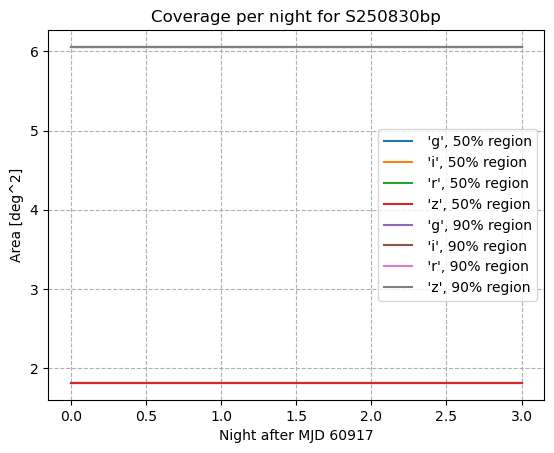

In [61]:
theBands = np.unique(simDF[nightMask]["band"])
nBands = len(theBands)

for d,cred in zip([tot50,tot90],["50","90"]):
    for b,n in zip(theBands,range(nBands)):
        plt.plot(np.arange(len(d[n::nBands])),d[n::nBands],label="{}, {}% region".format(b,cred))
        print("Total coverage of the {}% region in {} band for night {}:".format(cred,b,n),np.median(d[n::nBands]))
    
plt.grid(ls="--")
plt.legend()
plt.xlabel("Night after MJD {}".format(ev_start))
plt.ylabel("Area [deg^2]")
plt.title("Coverage per night for {}".format(ev_name))
plt.show()

Relative coverage of the 50% region in  'g' band for night 0: 18.873551465576003
Relative coverage of the 50% region in  'i' band for night 1: 18.873551465576003
Relative coverage of the 50% region in  'r' band for night 2: 18.873551465576003
Relative coverage of the 50% region in  'z' band for night 3: 18.873551465576003
Relative coverage of the 90% region in  'g' band for night 0: 62.94308111792773
Relative coverage of the 90% region in  'i' band for night 1: 62.94308111792773
Relative coverage of the 90% region in  'r' band for night 2: 62.94308111792773
Relative coverage of the 90% region in  'z' band for night 3: 62.94308111792773


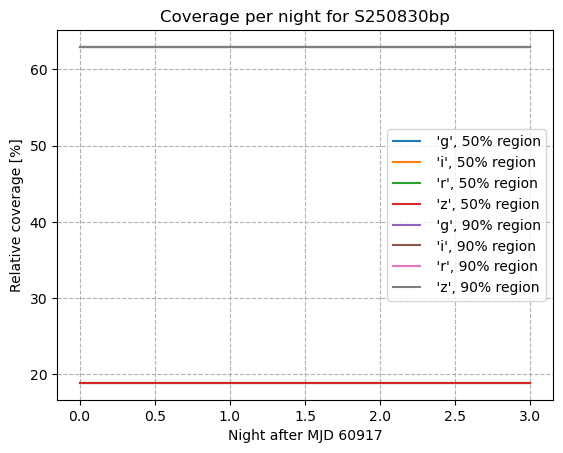

In [65]:
for d,cred in zip([frac50,frac90],["50","90"]):
    for b,n in zip(theBands,range(nBands)):
        plt.plot(np.arange(len(d[n::nBands])),d[n::nBands],label="{}, {}% region".format(b,cred))
        print("Relative coverage of the {}% region in {} band for night {}:".format(cred,b,n),np.median(d[n::nBands]))
    
plt.grid(ls="--")
plt.legend()
plt.xlabel("Night after MJD {}".format(ev_start))
plt.ylabel("Relative coverage [%]")
plt.title("Coverage per night for {}".format(ev_name))
plt.show()

1.5982219489534808
1.5982219489534808
1.5982219489534808
1.5982219489534808


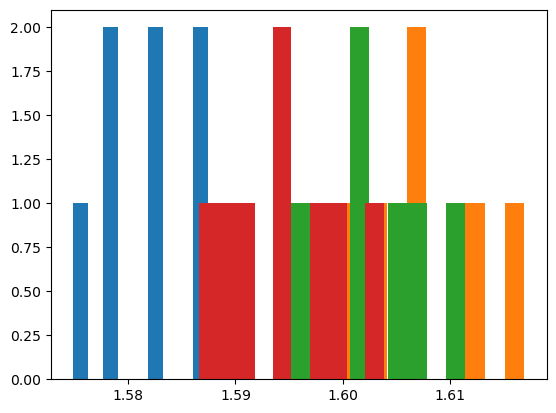

In [57]:
for n in np.unique(simDF["night"]):
    msk = simDF["night"] == n
    plt.hist(simDF[msk]["airmass"])
    print(np.median(simDF["airmass"]))